In [1]:
import pandas as pd
import umap
import numpy as np
import matplotlib.pyplot as plt
import randomcolor
import random
import seaborn as sns
from tcrdist.mappers import vdjdb_to_tcrdist2
from tcrdist.repertoire import TCRrep
from sklearn.preprocessing import normalize
from sklearn import cluster
from collections import Counter
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from pynndescent.utils import seed
from tcrdist.public import _neighbors_fixed_radius
from sklearn.metrics import silhouette_score

### Load Processed Data  
Rename the columns of the data to fit the tcrdist.  

In [2]:
# # read VDjdb dataset
# VDJdb = pd.read_csv("vdjdb.txt", sep = "\t")

# method = VDJdb['method']

# method_dict_component = []
# for row in range(0, method.index.stop, 1):
#     method_dict_component.append(json.loads(method[row])['frequency'])
    
# VDJdb['frequency'] = method_dict_component
# display(VDJdb)

In [3]:
# Load all data
VDJdb_TRA_human_fix = pd.read_csv('Processed_TRA_Conf_by_GIANA.csv')
display(VDJdb_TRA_human_fix)

VDJdb_TRA_human_fix = VDJdb_TRA_human_fix.rename(columns = {'V1': 'cdr3_a_aa', 'V3': 'v_a_gene', 'V4': 'j_a_gene', 'V6':'antigen.species'})
VDJdb_TRA_human_fix = VDJdb_TRA_human_fix[["cdr3_a_aa", "v_a_gene", "j_a_gene", "antigen.species"]]
display(VDJdb_TRA_human_fix)

Unnamed: 0                      V1   V2             V3  \
0                CAASFSDGQKLLF           CAASFSDGQKLLF    1    TRAV13-1*01   
1              CAASFSDGQKLLF.1           CAASFSDGQKLLF    1    TRAV13-1*01   
2                CAASIGAGNMLTF           CAASIGAGNMLTF    2  TRAV29/DV5*01   
3              CAASIGAGNMLTF.1           CAASIGAGNMLTF    2  TRAV29/DV5*01   
4                CAASMNGDDKIIF           CAASMNGDDKIIF    3  TRAV23/DV6*01   
...                        ...                     ...  ...            ...   
1498      CLVGSPVPFSGGYNKLIF.1      CLVGSPVPFSGGYNKLIF  416       TRAV4*01   
1499       CAADTLLNAGGTSYGKLTF     CAADTLLNAGGTSYGKLTF  417    TRAV13-1*01   
1500     CAADTLLNAGGTSYGKLTF.1     CAADTLLNAGGTSYGKLTF  417    TRAV13-1*01   
1501    CAAIPVRNGRMNYGGSQGNLIF  CAAIPVRNGRMNYGGSQGNLIF  418  TRAV29/DV5*01   
1502  CAAIPVRNGRMNYGGSQGNLIF.1  CAAIPVRNGRMNYGGSQGNLIF  418  TRAV29/DV5*01   

             V4             V5          V6      V6.1        V7        V8  ...  \
0           NaN  PKYVKQNTLKLAT  InfluenzaA -0.131946 -0.122627  0.180292  ...   
1           NaN  PKYVKQNTLKLAT  InfluenzaA -0.131946 -0.122627  0.180292  ...   
2     TRAJ39*01      NLVPMVATV         CMV -0.330413 -0.438601 -0.550938  ...   
3     TRAJ39*01      NLVPMVATV         CMV -0.330413 -0.438601 -0.550938  ...   
4     TRAJ30*01  GMFNMLSTVLGVS  InfluenzaA -0.422125  0.122257  0.162796  ...   
...         ...            ...         ...       ...       ...       ...  ...   
1498   TRAJ4*01      NLVPMVATV         CMV -0.462359 -0.561227 -0.370646  ...   
1499  TRAJ52*01      NLVPMVATV         CMV  0.247162 -0.242762 -0.928951  ...   
1500  TRAJ52*01      NLVPMVATV         CMV  0.247162 -0.242762 -0.928951  ...   
1501  TRAJ42*01      GILGFVFTL  InfluenzaA -0.660825 -0.877201 -1.101875  ...   
1502  TRAJ42*01      GILGFVFTL  InfluenzaA -0.660825 -0.877201 -1.101875  ...   

           V92       V93       V94       V95       V96       V97       V98  \
0    -0.600459 -0.090567  0.221479 -0.330294  0.556356 -0.541500  0.054591   
1    -0.600459 -0.090567  0.221479 -0.330294  0.556356 -0.541500  0.054591   
2     0.027839  0.026379 -0.417603  0.218099  0.535328  0.048330  0.078777   
3     0.027839  0.026379 -0.417603  0.218099  0.535328  0.048330  0.078777   
4     0.534093  0.548508  0.594903  0.326693 -0.453553 -0.563170 -0.554163   
...        ...       ...       ...       ...       ...       ...       ...   
1498  1.221860  1.126777  0.535163  0.207328 -0.574577 -0.784084 -0.119884   
1499  0.208611 -0.173046 -0.782782  0.103752 -0.537859  0.720856 -0.197778   
1500  0.208611 -0.173046 -0.782782  0.103752 -0.537859  0.720856 -0.197778   
1501 -0.484122  0.395205 -0.749790  0.869585 -0.586457  0.291919 -0.971622   
1502 -0.484122  0.395205 -0.749790  0.869585 -0.586457  0.291919 -0.971622   

           V99      V100      V101  
0     0.573342 -0.062271  0.652999  
1     0.573342 -0.062271  0.652999  
2     0.504649 -0.269721 -0.524168  
3     0.504649 -0.269721 -0.524168  
4     0.181178 -0.716009 -0.089898  
...        ...       ...       ...  
1498  0.895657 -0.388549 -0.055234  
1499 -0.009423 -0.952306  0.570936  
1500 -0.009423 -0.952306  0.570936  
1501 -0.284567 -0.042783  0.375740  
1502 -0.284567 -0.042783  0.375740  

[1503 rows x 103 columns]

cdr3_a_aa       v_a_gene   j_a_gene antigen.species
0              CAASFSDGQKLLF    TRAV13-1*01        NaN      InfluenzaA
1              CAASFSDGQKLLF    TRAV13-1*01        NaN      InfluenzaA
2              CAASIGAGNMLTF  TRAV29/DV5*01  TRAJ39*01             CMV
3              CAASIGAGNMLTF  TRAV29/DV5*01  TRAJ39*01             CMV
4              CAASMNGDDKIIF  TRAV23/DV6*01  TRAJ30*01      InfluenzaA
...                      ...            ...        ...             ...
1498      CLVGSPVPFSGGYNKLIF       TRAV4*01   TRAJ4*01             CMV
1499     CAADTLLNAGGTSYGKLTF    TRAV13-1*01  TRAJ52*01             CMV
1500     CAADTLLNAGGTSYGKLTF    TRAV13-1*01  TRAJ52*01             CMV
1501  CAAIPVRNGRMNYGGSQGNLIF  TRAV29/DV5*01  TRAJ42*01      InfluenzaA
1502  CAAIPVRNGRMNYGGSQGNLIF  TRAV29/DV5*01  TRAJ42*01      InfluenzaA

[1503 rows x 4 columns]

In [13]:
# Rename the columns of the data
VDJdb_Paired_human = pd.read_csv('VDJdb_Paired.tsv', sep='\t')
# display(VDJdb_Paired_human)
VDJdb_Conf_human = VDJdb_Paired_human[VDJdb_Paired_human["Score"]>0]

VDJdb_Paired_human = vdjdb_to_tcrdist2(VDJdb_Paired_human)
VDJdb_TRA_human = VDJdb_Paired_human[["cdr3_a_aa", "v_a_gene", "j_a_gene", "organism", "epitope_aa", "frequency", "count"]]
VDJdb_TRB_human = VDJdb_Paired_human[["cdr3_b_aa", "v_b_gene", "j_b_gene", "organism", "epitope_aa", "frequency", "count"]]
# VDJdb_TRB_human.to_csv("data/VDJdb_Paired_human.txt", sep='\t', index=False)
# VDJdb_TRA_human.to_csv("data/VDJdb_TRA_human.txt", sep='\t', index=False)
# VDJdb_TRB_human.to_csv("data/VDJdb_TRB_human.txt", sep='\t', index=False)
# display(VDJdb_Paired_human)


VDJdb_Conf_Paired_human = vdjdb_to_tcrdist2(VDJdb_Conf_human)
# VDJdb_Conf_Paired_human.to_csv("VDJdb_Conf_Paired_human.tsv", sep='\t', index=False)
# display(VDJdb_Conf_Paired_human)
display(VDJdb_Conf_human)


VDJdb_Paired_Conf_human = VDJdb_Conf_Paired_human[["cdr3_a_aa", "v_a_gene", "j_a_gene", "cdr3_b_aa", "v_b_gene", "j_b_gene", "organism", "epitope_aa", "frequency", "count"]]
VDJdb_TRA_Conf_human = VDJdb_Conf_Paired_human[["cdr3_a_aa", "v_a_gene", "j_a_gene", "organism", "epitope_aa", "frequency", "count"]]
VDJdb_TRB_Conf_human = VDJdb_Conf_Paired_human[["cdr3_b_aa", "v_b_gene", "j_b_gene", "organism", "epitope_aa", "frequency", "count"]]
# VDJdb_TRA_Conf_human.to_csv("data/VDJdb_TRA_Conf_human.txt", sep='\t', index=False)
# VDJdb_TRB_Conf_human.to_csv("data/VDJdb_TRB_Conf_human.txt", sep='\t', index=False)
# VDJdb_Paired_Conf_human.to_csv("data/VDJdb_TRB_Conf_human.txt", sep='\t', index=False) 
 
display(VDJdb_Paired_Conf_human)    
display(VDJdb_TRA_Conf_human)  
display(VDJdb_TRB_Conf_human)

# VDJdb_TRA_human_fix = VDJdb_TRA_human_fix.rename(columns = {'cdr3': 'cdr3_a_aa', 'v.segm': 'v_a_gene', 'j.segm': 'j_a_gene'})
# VDJdb_TRA_human_fix = VDJdb_TRA_human_fix[["cdr3_a_aa", "v_a_gene", "j_a_gene", "antigen.species", "antigen.epitope"]]
# VDJdb_TRA_human_fix = VDJdb_TRA_human_fix.dropna(subset = ["cdr3_a_aa", "v_a_gene", "j_a_gene"])
# display(VDJdb_TRA_human_fix)

# VDJdb_TRA_human_fix["cdr3_a_aa"] = [x[4:-1] for x in VDJdb_TRA_human_fix["cdr3_a_aa"]]
# display(VDJdb_TRA_human_fix)

complex.id Gene                 CDR3                V           J  \
0               1  TRA        CIVRAPGRADMRF      TRAV26-1*01   TRAJ43*01   
1               2  TRA       CAVPSGAGSYQLTF        TRAV20*01   TRAJ28*01   
2               4  TRA        CAYRPPGTYKYIF  TRAV38-2/DV8*01   TRAJ40*01   
3               5  TRA        CIVRAPGRADMRF      TRAV26-1*01   TRAJ43*01   
4               6  TRA       CAVPSGAGSYQLTF        TRAV20*01   TRAJ28*01   
...           ...  ...                  ...              ...         ...   
51305       29262  TRB      CASSWNGLAGDEQFF       TRBV6-2*01  TRBJ2-1*01   
51306       29263  TRB     CASSALVAFSTDTQYF       TRBV6-4*01  TRBJ2-3*01   
51307       29264  TRB      CASSSLAGEVNEQFF       TRBV7-2*01  TRBJ2-1*01   
51308       29265  TRB  CASSSYTQRGLDYTGELFF        TRBV27*01  TRBJ2-2*01   
51309       29266  TRB    CASSQDYWGGGADTQYF       TRBV4-1*01  TRBJ2-3*01   

           Species        MHC A MHC B MHC class    Epitope Epitope gene  \
0      HomoSapiens     HLA-B*08   B2M      MHCI   FLKEKGGL          Nef   
1      HomoSapiens     HLA-B*08   B2M      MHCI   FLKEKGGL          Nef   
2      HomoSapiens     HLA-B*08   B2M      MHCI   FLKEKGGL          Nef   
3      HomoSapiens     HLA-B*08   B2M      MHCI   FLKEQGGL          Nef   
4      HomoSapiens     HLA-B*08   B2M      MHCI   FLKEQGGL          Nef   
...            ...          ...   ...       ...        ...          ...   
51305  HomoSapiens  HLA-A*24:01   B2M      MHCI  QYIKWPWYI        Spike   
51306  HomoSapiens  HLA-A*24:01   B2M      MHCI  QYIKWPWYI        Spike   
51307  HomoSapiens  HLA-A*24:01   B2M      MHCI  QYIKWPWYI        Spike   
51308  HomoSapiens  HLA-A*24:01   B2M      MHCI  QYIKWPWYI        Spike   
51309  HomoSapiens  HLA-A*24:01   B2M      MHCI  QYIKWPWYI        Spike   

      Epitope species      Reference  \
0               HIV-1  PMID:15596521   
1               HIV-1  PMID:15596521   
2               HIV-1  PMID:15596521   
3               HIV-1  PMID:15596521   
4               HIV-1  PMID:15596521   
...               ...            ...   
51305      SARS-CoV-2  PMID:34086357   
51306      SARS-CoV-2  PMID:34086357   
51307      SARS-CoV-2  PMID:34086357   
51308      SARS-CoV-2  PMID:34086357   
51309      SARS-CoV-2  PMID:34086357   

                                                  Method  \
0      {"frequency": "", "identification": "tetramer-...   
1      {"frequency": "", "identification": "tetramer-...   
2      {"frequency": "", "identification": "tetramer-...   
3      {"frequency": "", "identification": "tetramer-...   
4      {"frequency": "", "identification": "tetramer-...   
...                                                  ...   
51305  {"frequency": "1/11", "identification": "tetra...   
51306  {"frequency": "1/11", "identification": "tetra...   
51307  {"frequency": "1/11", "identification": "tetra...   
51308  {"frequency": "1/11", "identification": "tetra...   
51309  {"frequency": "2/11", "identification": "tetra...   

                                                    Meta  \
0      {"cell.subset": "CD8+", "clone.id": "", "donor...   
1      {"cell.subset": "CD8+", "clone.id": "", "donor...   
2      {"cell.subset": "CD8+", "clone.id": "", "donor...   
3      {"cell.subset": "CD8+", "clone.id": "", "donor...   
4      {"cell.subset": "CD8+", "clone.id": "", "donor...   
...                                                  ...   
51305  {"cell.subset": "CD8+", "clone.id": "", "donor...   
51306  {"cell.subset": "CD8+", "clone.id": "", "donor...   
51307  {"cell.subset": "CD8+", "clone.id": "", "donor...   
51308  {"cell.subset": "CD8+", "clone.id": "", "donor...   
51309  {"cell.subset": "CD8+", "clone.id": "", "donor...   

                                                 CDR3fix  Score  
0      {"cdr3": "CIVRAPGRADMRF", "cdr3_old": "CIVRAPG...      2  
1      {"cdr3": "CAVPSGAGSYQLTF", "cdr3_old": "CAVPSG...      2  
2      {"cdr3": "CAYRPPGTYKYIF", "cdr3_old": "CAYRPPG...      2  
3     

cdr3_a_aa         v_a_gene   j_a_gene             cdr3_b_aa  \
0        CIVRAPGRADMRF      TRAV26-1*01  TRAJ43*01  CASSYLPGQGDHYSNQPQHF   
1       CAVPSGAGSYQLTF        TRAV20*01  TRAJ28*01   CASSFEPGQGFYSNQPQHF   
2        CAYRPPGTYKYIF  TRAV38-2/DV8*01  TRAJ40*01        CASSALASLNEQFF   
3        CIVRAPGRADMRF      TRAV26-1*01  TRAJ43*01  CASSYLPGQGDHYSNQPQHF   
4       CAVPSGAGSYQLTF        TRAV20*01  TRAJ28*01   CASSFEPGQGFYSNQPQHF   
...                ...              ...        ...                   ...   
1610  CAFLNAGGTSYGKLTF      TRAV38-1*01  TRAJ52*01       CASSWNGLAGDEQFF   
1611      CAVYNQGGKLIF       TRAV8-1*01  TRAJ23*01      CASSALVAFSTDTQYF   
1612    CAVRALYNFNKFYF         TRAV3*01  TRAJ21*01       CASSSLAGEVNEQFF   
1613     CAVESYNTDKLIF        TRAV41*01  TRAJ34*01   CASSSYTQRGLDYTGELFF   
1614  CAMREGQGNAGNMLTF    TRAV14/DV4*01  TRAJ39*01     CASSQDYWGGGADTQYF   

        v_b_gene    j_b_gene     organism epitope_aa frequency  count  
0      TRBV13*01  TRBJ1-5*01  HomoSapiens   FLKEKGGL                1  
1      TRBV13*01  TRBJ1-5*01  HomoSapiens   FLKEKGGL                1  
2      TRBV14*01  TRBJ2-1*01  HomoSapiens   FLKEKGGL                1  
3      TRBV13*01  TRBJ1-5*01  HomoSapiens   FLKEQGGL                1  
4      TRBV13*01  TRBJ1-5*01  HomoSapiens   FLKEQGGL                1  
...          ...         ...          ...        ...       ...    ...  
1610  TRBV6-2*01  TRBJ2-1*01  HomoSapiens  QYIKWPWYI      1/11      1  
1611  TRBV6-4*01  TRBJ2-3*01  HomoSapiens  QYIKWPWYI      1/11      1  
1612  TRBV7-2*01  TRBJ2-1*01  HomoSapiens  QYIKWPWYI      1/11      1  
1613   TRBV27*01  TRBJ2-2*01  HomoSapiens  QYIKWPWYI      1/11      1  
1614  TRBV4-1*01  TRBJ2-3*01  HomoSapiens  QYIKWPWYI      2/11      2  

[1615 rows x 10 columns]

cdr3_a_aa         v_a_gene   j_a_gene     organism epitope_aa  \
0        CIVRAPGRADMRF      TRAV26-1*01  TRAJ43*01  HomoSapiens   FLKEKGGL   
1       CAVPSGAGSYQLTF        TRAV20*01  TRAJ28*01  HomoSapiens   FLKEKGGL   
2        CAYRPPGTYKYIF  TRAV38-2/DV8*01  TRAJ40*01  HomoSapiens   FLKEKGGL   
3        CIVRAPGRADMRF      TRAV26-1*01  TRAJ43*01  HomoSapiens   FLKEQGGL   
4       CAVPSGAGSYQLTF        TRAV20*01  TRAJ28*01  HomoSapiens   FLKEQGGL   
...                ...              ...        ...          ...        ...   
1610  CAFLNAGGTSYGKLTF      TRAV38-1*01  TRAJ52*01  HomoSapiens  QYIKWPWYI   
1611      CAVYNQGGKLIF       TRAV8-1*01  TRAJ23*01  HomoSapiens  QYIKWPWYI   
1612    CAVRALYNFNKFYF         TRAV3*01  TRAJ21*01  HomoSapiens  QYIKWPWYI   
1613     CAVESYNTDKLIF        TRAV41*01  TRAJ34*01  HomoSapiens  QYIKWPWYI   
1614  CAMREGQGNAGNMLTF    TRAV14/DV4*01  TRAJ39*01  HomoSapiens  QYIKWPWYI   

     frequency  count  
0                   1  
1                   1  
2                   1  
3                   1  
4                   1  
...        ...    ...  
1610      1/11      1  
1611      1/11      1  
1612      1/11      1  
1613      1/11      1  
1614      2/11      2  

[1615 rows x 7 columns]

cdr3_b_aa    v_b_gene    j_b_gene     organism epitope_aa  \
0     CASSYLPGQGDHYSNQPQHF   TRBV13*01  TRBJ1-5*01  HomoSapiens   FLKEKGGL   
1      CASSFEPGQGFYSNQPQHF   TRBV13*01  TRBJ1-5*01  HomoSapiens   FLKEKGGL   
2           CASSALASLNEQFF   TRBV14*01  TRBJ2-1*01  HomoSapiens   FLKEKGGL   
3     CASSYLPGQGDHYSNQPQHF   TRBV13*01  TRBJ1-5*01  HomoSapiens   FLKEQGGL   
4      CASSFEPGQGFYSNQPQHF   TRBV13*01  TRBJ1-5*01  HomoSapiens   FLKEQGGL   
...                    ...         ...         ...          ...        ...   
1610       CASSWNGLAGDEQFF  TRBV6-2*01  TRBJ2-1*01  HomoSapiens  QYIKWPWYI   
1611      CASSALVAFSTDTQYF  TRBV6-4*01  TRBJ2-3*01  HomoSapiens  QYIKWPWYI   
1612       CASSSLAGEVNEQFF  TRBV7-2*01  TRBJ2-1*01  HomoSapiens  QYIKWPWYI   
1613   CASSSYTQRGLDYTGELFF   TRBV27*01  TRBJ2-2*01  HomoSapiens  QYIKWPWYI   
1614     CASSQDYWGGGADTQYF  TRBV4-1*01  TRBJ2-3*01  HomoSapiens  QYIKWPWYI   

     frequency  count  
0                   1  
1                   1  
2                   1  
3                   1  
4                   1  
...        ...    ...  
1610      1/11      1  
1611      1/11      1  
1612      1/11      1  
1613      1/11      1  
1614      2/11      2  

[1615 rows x 7 columns]

In [77]:
# Rename the columns of the data
# VDJdb_TRA_human_fix = pd.read_csv('VDJdb_TRA_human_Conf_GIANA.txt', sep='\t')
# display(VDJdb_TRA_human_fix)

# VDJdb_TRA_human_fix = VDJdb_TRA_human_fix.rename(columns = {'cdr3': 'cdr3_a_aa', 'v.segm': 'v_a_gene', 'j.segm': 'j_a_gene'})
# VDJdb_TRA_human_fix = VDJdb_TRA_human_fix[["cdr3_a_aa", "v_a_gene", "j_a_gene", "antigen.species", "antigen.epitope"]]
# VDJdb_TRA_human_fix = VDJdb_TRA_human_fix.dropna(subset = ["cdr3_a_aa", "v_a_gene", "j_a_gene"])
# display(VDJdb_TRA_human_fix)

VDJdb_TRA_human_fix = VDJdb_Conf_Paired_human[["cdr3_a_aa", "v_a_gene", "j_a_gene", "organism", "epitope_aa", "count"]]


VDJdb_TRA_human_fix["cdr3_a_aa"] = [x[4:-1] for x in VDJdb_TRA_human_fix["cdr3_a_aa"]]
display(VDJdb_TRA_human_fix)

<ipython-input-77-987f341ca886>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  VDJdb_TRA_human_fix["cdr3_a_aa"] = [x[4:-1] for x in VDJdb_TRA_human_fix["cdr3_a_aa"]]


cdr3_a_aa         v_a_gene   j_a_gene     organism epitope_aa  count
0        APGRADMR      TRAV26-1*01  TRAJ43*01  HomoSapiens   FLKEKGGL      1
1       SGAGSYQLT        TRAV20*01  TRAJ28*01  HomoSapiens   FLKEKGGL      1
2        PPGTYKYI  TRAV38-2/DV8*01  TRAJ40*01  HomoSapiens   FLKEKGGL      1
3        APGRADMR      TRAV26-1*01  TRAJ43*01  HomoSapiens   FLKEQGGL      1
4       SGAGSYQLT        TRAV20*01  TRAJ28*01  HomoSapiens   FLKEQGGL      1
...           ...              ...        ...          ...        ...    ...
1610  NAGGTSYGKLT      TRAV38-1*01  TRAJ52*01  HomoSapiens  QYIKWPWYI      1
1611      NQGGKLI       TRAV8-1*01  TRAJ23*01  HomoSapiens  QYIKWPWYI      1
1612    ALYNFNKFY         TRAV3*01  TRAJ21*01  HomoSapiens  QYIKWPWYI      1
1613     SYNTDKLI        TRAV41*01  TRAJ34*01  HomoSapiens  QYIKWPWYI      1
1614  EGQGNAGNMLT    TRAV14/DV4*01  TRAJ39*01  HomoSapiens  QYIKWPWYI      2

[1615 rows x 6 columns]

In [78]:
# Rename the columns of the data
# VDJdb_TRB_human_fix = pd.read_csv('VDJdb_TRB_human_Conf_GIANA.txt', sep='\t')
# display(VDJdb_TRB_human_fix)

# VDJdb_TRB_human_fix = VDJdb_TRB_human_fix.rename(columns = {'cdr3': 'cdr3_b_aa', 'v.segm': 'v_b_gene', 'j.segm': 'j_b_gene'})
# VDJdb_TRB_human_fix = VDJdb_TRB_human_fix[["cdr3_b_aa", "v_b_gene", "j_b_gene", "antigen.species", "antigen.epitope"]]
# VDJdb_TRB_human_fix = VDJdb_TRB_human_fix.dropna(subset = ["cdr3_b_aa", "v_b_gene", "j_b_gene"])
# display(VDJdb_TRB_human_fix)

VDJdb_TRB_human_fix = VDJdb_Conf_Paired_human[["cdr3_b_aa", "v_b_gene", "j_b_gene", "organism", "epitope_aa", "count"]]

VDJdb_TRB_human_fix["cdr3_b_aa"] = [x[4:-1] for x in VDJdb_TRB_human_fix["cdr3_b_aa"]]
display(VDJdb_TRB_human_fix)

<ipython-input-78-eeef04babb57>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  VDJdb_TRB_human_fix["cdr3_b_aa"] = [x[4:-1] for x in VDJdb_TRB_human_fix["cdr3_b_aa"]]


cdr3_b_aa    v_b_gene    j_b_gene     organism epitope_aa  count
0     YLPGQGDHYSNQPQH   TRBV13*01  TRBJ1-5*01  HomoSapiens   FLKEKGGL      1
1      FEPGQGFYSNQPQH   TRBV13*01  TRBJ1-5*01  HomoSapiens   FLKEKGGL      1
2           ALASLNEQF   TRBV14*01  TRBJ2-1*01  HomoSapiens   FLKEKGGL      1
3     YLPGQGDHYSNQPQH   TRBV13*01  TRBJ1-5*01  HomoSapiens   FLKEQGGL      1
4      FEPGQGFYSNQPQH   TRBV13*01  TRBJ1-5*01  HomoSapiens   FLKEQGGL      1
...               ...         ...         ...          ...        ...    ...
1610       WNGLAGDEQF  TRBV6-2*01  TRBJ2-1*01  HomoSapiens  QYIKWPWYI      1
1611      ALVAFSTDTQY  TRBV6-4*01  TRBJ2-3*01  HomoSapiens  QYIKWPWYI      1
1612       SLAGEVNEQF  TRBV7-2*01  TRBJ2-1*01  HomoSapiens  QYIKWPWYI      1
1613   SYTQRGLDYTGELF   TRBV27*01  TRBJ2-2*01  HomoSapiens  QYIKWPWYI      1
1614     QDYWGGGADTQY  TRBV4-1*01  TRBJ2-3*01  HomoSapiens  QYIKWPWYI      2

[1615 rows x 6 columns]

In [3]:
# Call the function to generate a tcr tree for alpha chain
# df_beta = VDJdb_TRB_human_fix
df_beta = VDJdb_TRB_Conf_human
tr_beta = TCRrep(cell_df = df_beta,
            organism = 'human',
            chains = ['beta'],
            deduplicate = False,
            db_file = "alphabeta_gammadelta_db.tsv",
            compute_distances=False)

In [4]:
# Compute alpha chain distance matrix 
tr_beta.compute_distances()

In [5]:
# Print distance matrix
dist_matrix_beta = tr_beta.pw_beta
print(dist_matrix_beta)
dist_matrix_beta.shape
#print(_neighbors_fixed_radius(dist_matrix_alpha, 100))

[[  0  39 179 ... 182 195 199]
 [ 39   0 179 ... 182 198 181]
 [179 179   0 ...  73 186 165]
 ...
 [182 182  73 ...   0 192 149]
 [195 198 186 ... 192   0 198]
 [199 181 165 ... 149 198   0]]


(1615, 1615)

In [8]:
#VDJdb_TRA_human_fix = pd.read_csv('VDJdb_TRA_human_fix.csv')
#display(VDJdb_TRA_human_fix)

# Call the function to generate a tcr tree for alpha chain
# df_alpha = VDJdb_TRA_human_fix
df_alpha = VDJdb_TRA_Conf_human
tr_alpha = TCRrep(cell_df = df_alpha,
            organism = 'human',
            chains = ['alpha'],
            deduplicate = False,
            db_file = "alphabeta_gammadelta_db.tsv",
            compute_distances=False)

In [9]:
# Compute alpha chain distance matrix 
tr_alpha.compute_distances()

In [21]:
# Print distance matrix
dist_matrix_alpha = tr_alpha.pw_alpha
print(dist_matrix_alpha)
dist_matrix_alpha.shape
#print(_neighbors_fixed_radius(dist_matrix_alpha, 100))

[[  0 138 110 ... 136 147 164]
 [138   0 131 ... 153 117 139]
 [110 131   0 ... 137 131 149]
 ...
 [136 153 137 ...   0 119 168]
 [147 117 131 ... 119   0 173]
 [164 139 149 ... 168 173   0]]


(1615, 1615)

In [14]:
# Call the function to generate a tcr tree for alpha chain
df_paired = VDJdb_Paired_Conf_human
tr_paired = TCRrep(cell_df = df_paired,
            organism = 'human',
            chains = ['alpha', 'beta'],
            deduplicate = False,
            db_file = "alphabeta_gammadelta_db.tsv",
            compute_distances=False)

In [16]:
# Compute alpha chain distance matrix 
tr_paired.compute_distances()

In [17]:
# Print distance matrix
dist_matrix_alpha_p = tr_paired.pw_alpha
dist_matrix_beta_p = tr_paired.pw_beta
dist_matrix_paired = dist_matrix_alpha_p + dist_matrix_beta_p
print(dist_matrix_paired)
dist_matrix_paired.shape
#print(_neighbors_fixed_radius(dist_matrix_alpha, 100))

[[  0 177 289 ... 318 342 363]
 [177   0 310 ... 335 315 320]
 [289 310   0 ... 210 317 314]
 ...
 [318 335 210 ...   0 311 317]
 [342 315 317 ... 311   0 371]
 [363 320 314 ... 317 371   0]]


(1615, 1615)

In [18]:
# dist_matrix_alpha_beta = np.concatenate((dist_matrix_alpha, dist_matrix_beta),axis=1)
# print(dist_matrix_alpha_beta)

In [22]:
# Normolize the distance matrix
Nor_dist_matrix_alpha = normalize(dist_matrix_alpha, axis=1, norm='l1')
Nor_dist_matrix_beta = normalize(dist_matrix_beta, axis=1, norm='l1')
Nor_dist_matrix_alpha_beta = normalize(dist_matrix_paired, axis=1, norm='l1')

In [23]:
# To define two methods to plot the umap dimension reduction results.
def draw_scatter(epitope, UMAP_fit, label):
    class_list = np.unique(epitope)  # 21个label
    n_class = len(class_list)  # label类别数
    palette = sns.hls_palette(n_colors=n_class)  # 配色方案
    plt.figure(figsize=(8, 8))
    
    for idx, species in enumerate(class_list):  # 遍历每个类别
        # 获取颜色和点型
        color = palette[idx]
        #marker = marker_list[idx % len(marker_list)]
        # 找到所有标注类别为当前类别的图像索引号
        indices = np.where(epitope == species)
        plt.scatter(UMAP_fit[indices, 0], UMAP_fit[indices, 1], color=color, label=label.iloc[species,0], s=30)  # , s=150
    plt.legend(fontsize=10, markerscale=1, bbox_to_anchor=(1, 1))
    
    
def label_gen(data):
    VDJ_test = data
    epitope = VDJ_test['epitope_aa']
    epitope = pd.Categorical(epitope).codes
    spec_label_rep = pd.DataFrame({"antitope":data['epitope_aa'], "label":epitope})
    spec_label = spec_label_rep.drop_duplicates(keep='first')
    spec_label = spec_label.sort_values("label")
    #display(TRA_spec_label)
    return spec_label, epitope

In [93]:
# VDJ_test = VDJdb_TRA_human_fix
# TRA_epitope_species = VDJ_test['antigen.species']
# TRA_epitope_label = pd.Categorical(TRA_epitope_species).codes
# TRA_labels_len = len(set(TRA_epitope_label))
# print(TRA_epitope_label)

D:\Anaconda Python\lib\site-packages\umap\umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


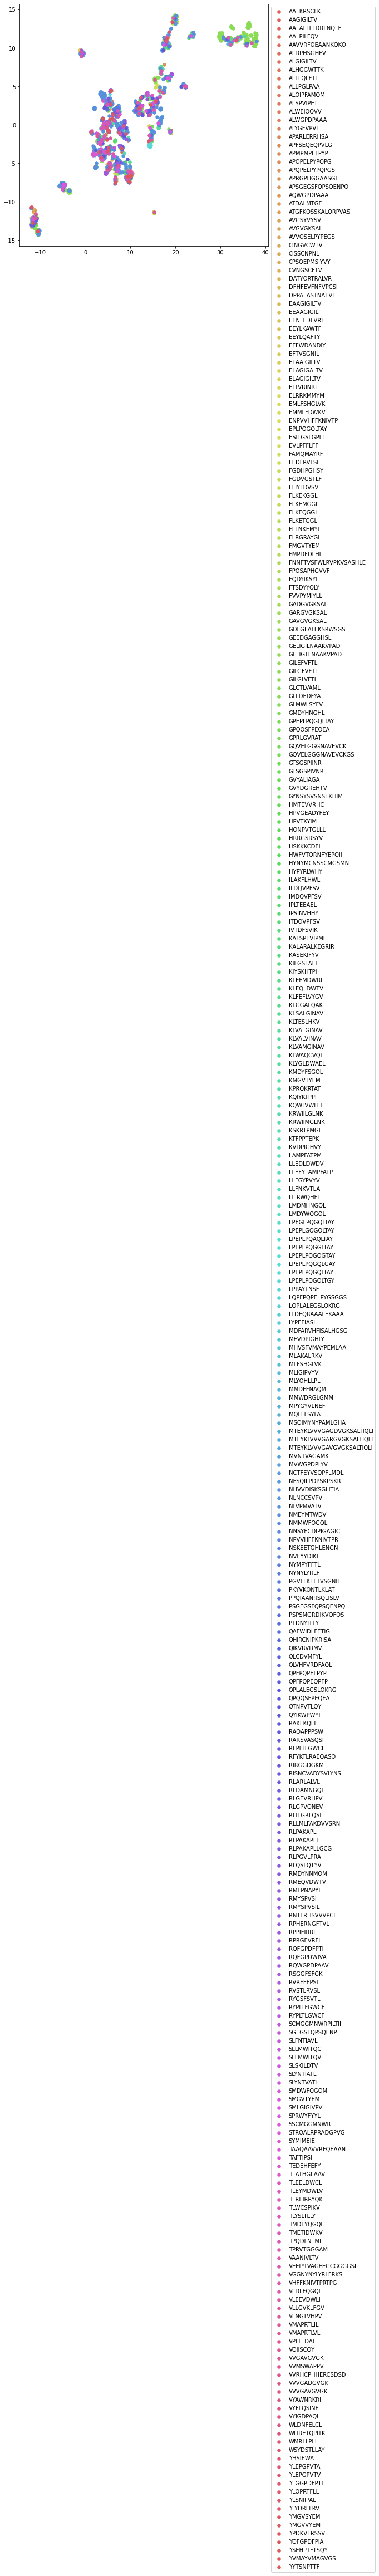

In [25]:
# To create a UMAP model
# pca100 = PCA(n_components=100)
# pca_fit = pca100.fit_transform(Nor_dist_matrix_alpha)
umap_TRB = umap.UMAP(random_state=42, n_components=2, min_dist=0.5, metric = 'precomputed')

TRB_spec_label, TRB_epitope = label_gen(VDJdb_TRB_Conf_human)

TRB_umap_fit = umap_TRB.fit_transform(Nor_dist_matrix_beta)

draw_scatter(TRB_epitope, TRB_umap_fit, TRB_spec_label)

D:\Anaconda Python\lib\site-packages\umap\umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


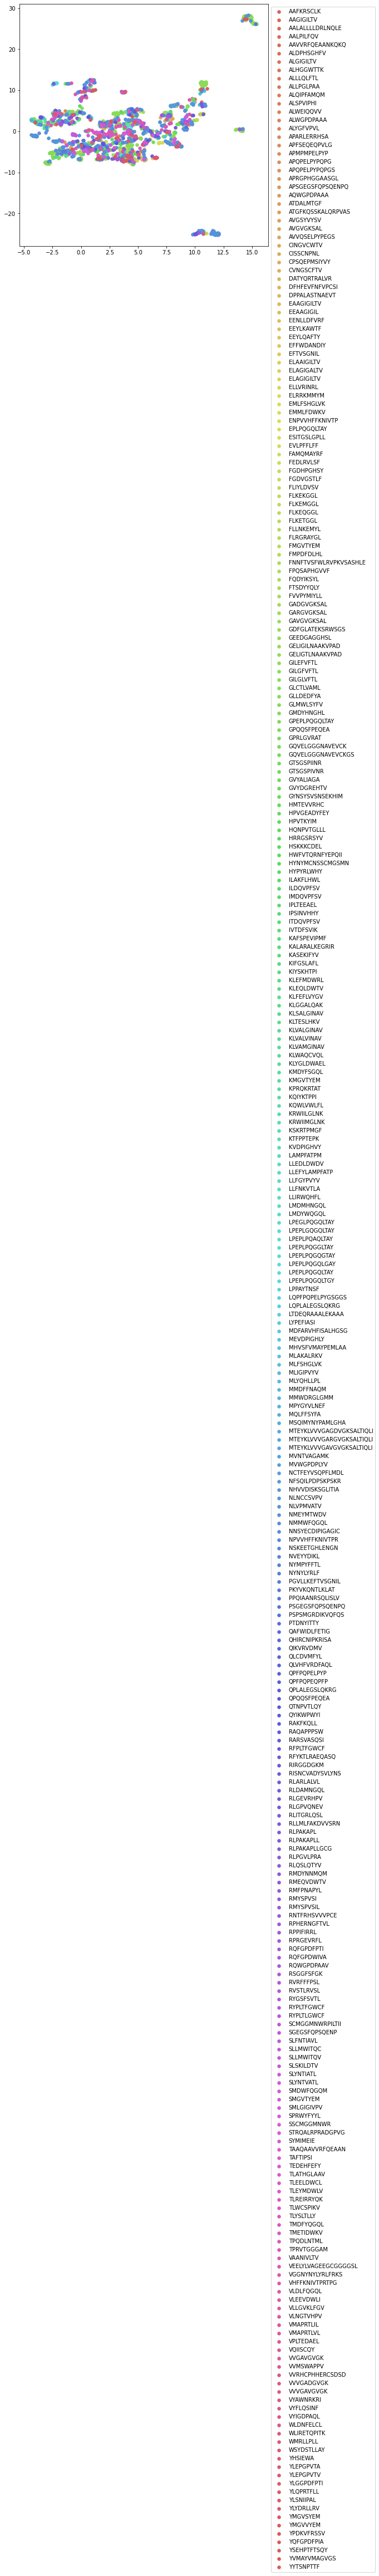

In [26]:
# To create a UMAP model
# pca100 = PCA(n_components=100)
# pca_fit = pca100.fit_transform(Nor_dist_matrix_alpha)
umap_TRA = umap.UMAP(random_state=42, n_components=2, min_dist=0.5, metric = 'precomputed')

TRA_spec_label, epitope = label_gen(VDJdb_TRA_Conf_human)

TRA_umap_fit = umap_TRA.fit_transform(Nor_dist_matrix_alpha)

draw_scatter(epitope, TRA_umap_fit, TRA_spec_label)

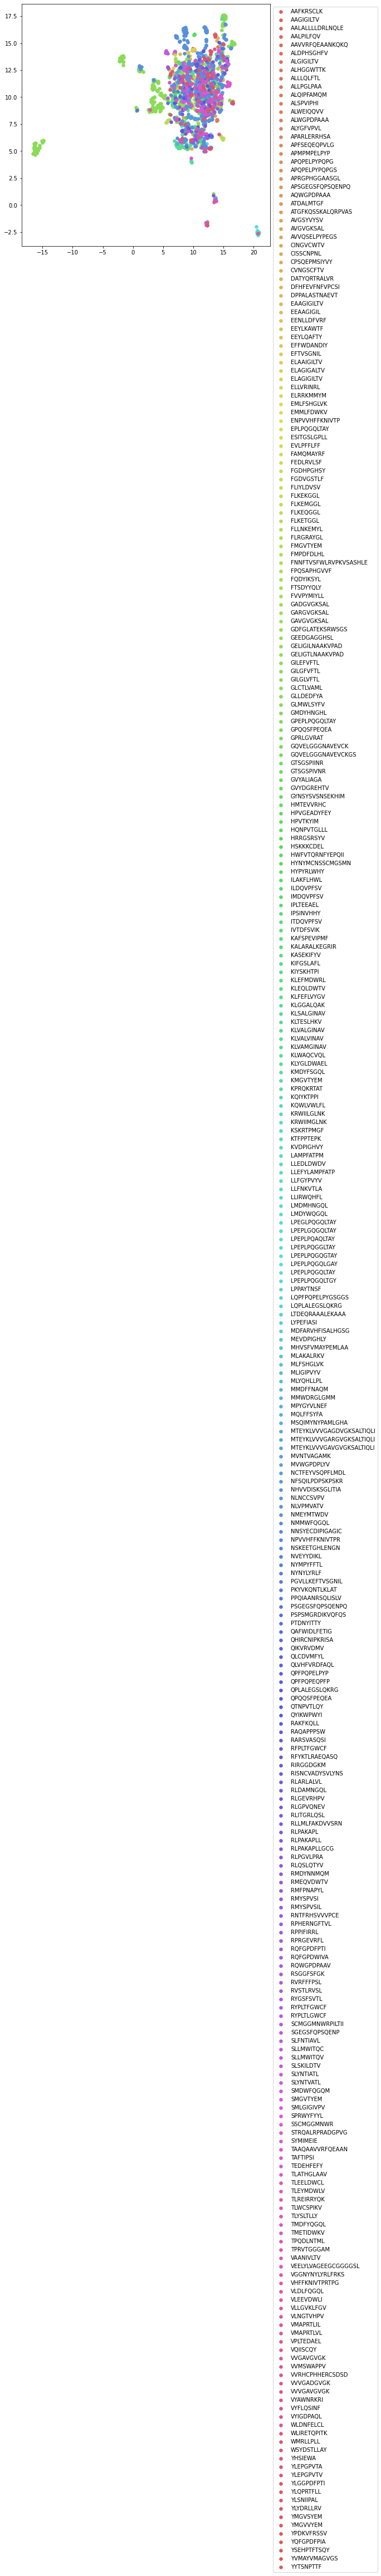

In [33]:
# To create a UMAP model
# pca100 = PCA(n_components=100)
# pca_fit = pca100.fit_transform(Nor_dist_matrix_alpha)
umap_Paired = umap.UMAP(random_state=42, n_components=2, min_dist=0.5)

Paired_spec_label, Paired_epitope = label_gen(VDJdb_Paired_Conf_human)

Paired_umap_fit = umap_Paired.fit_transform(Nor_dist_matrix_alpha_beta)

draw_scatter(Paired_epitope, Paired_umap_fit, Paired_spec_label)

In [28]:
print(TRA_spec_label)
print(epitope)

             antitope  label
715         AAFKRSCLK      0
67          AAGIGILTV      1
1454  AALALLLLDRLNQLE      2
1434        AALPILFQV      3
23    AAVVRFQEAANKQKQ      4
...               ...    ...
282        YPDKVFRSSV    302
114        YQFGPDFPIA    303
230       YSEHPTFTSQY    304
1373     YVMAYVMAGVGS    305
1553        YYTSNPTTF    306

[307 rows x 2 columns]
[ 58  58  58 ... 204 204 204]


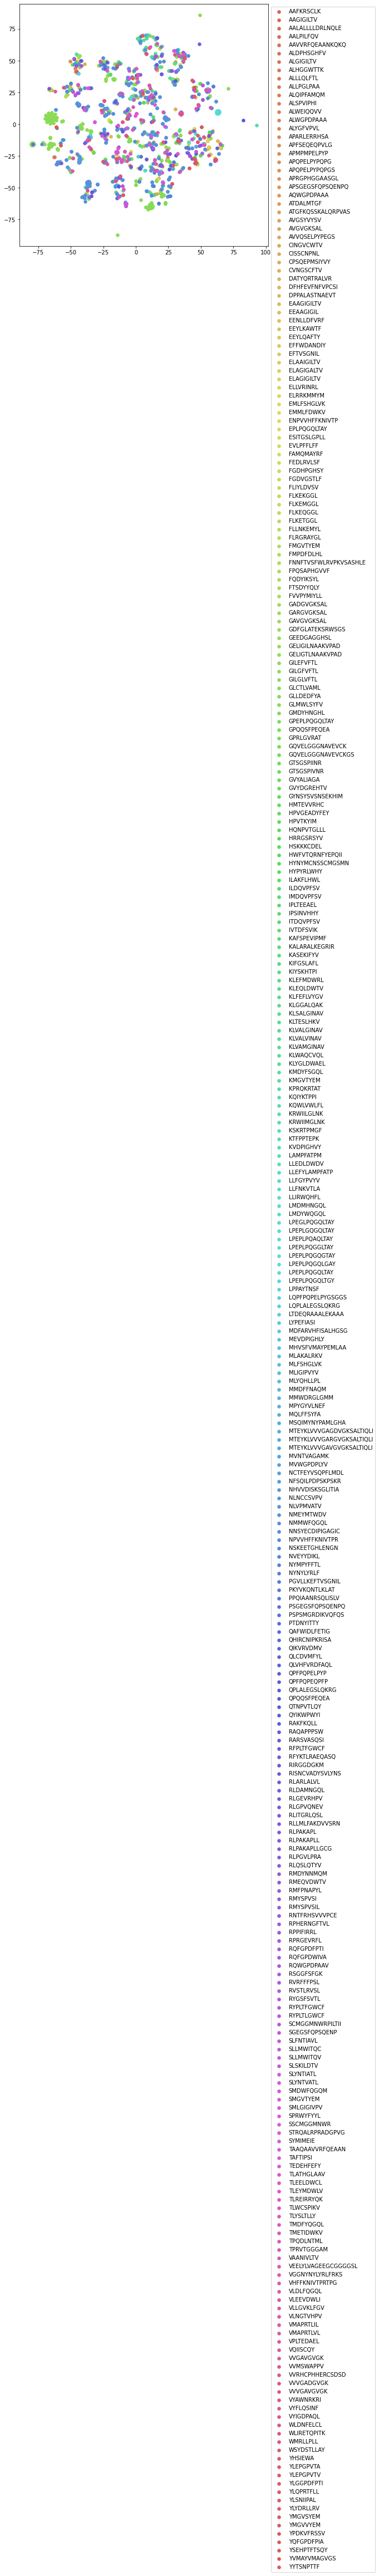

In [30]:
# pca100 = PCA(n_components=100)
# pca_fit = pca100.fit_transform(Nor_dist_matrix_alpha)

TSNE_TRA = TSNE(random_state=42, perplexity=10, init='random', metric = 'precomputed').fit_transform(Nor_dist_matrix_alpha)
TRA_spec_label, TRA_epitope = label_gen(VDJdb_TRA_Conf_human)

#TRA_TSNE_fit = TSNE_TRA.fit_transform(pca_fit)

draw_scatter(TRA_epitope, TSNE_TRA, TRA_spec_label)

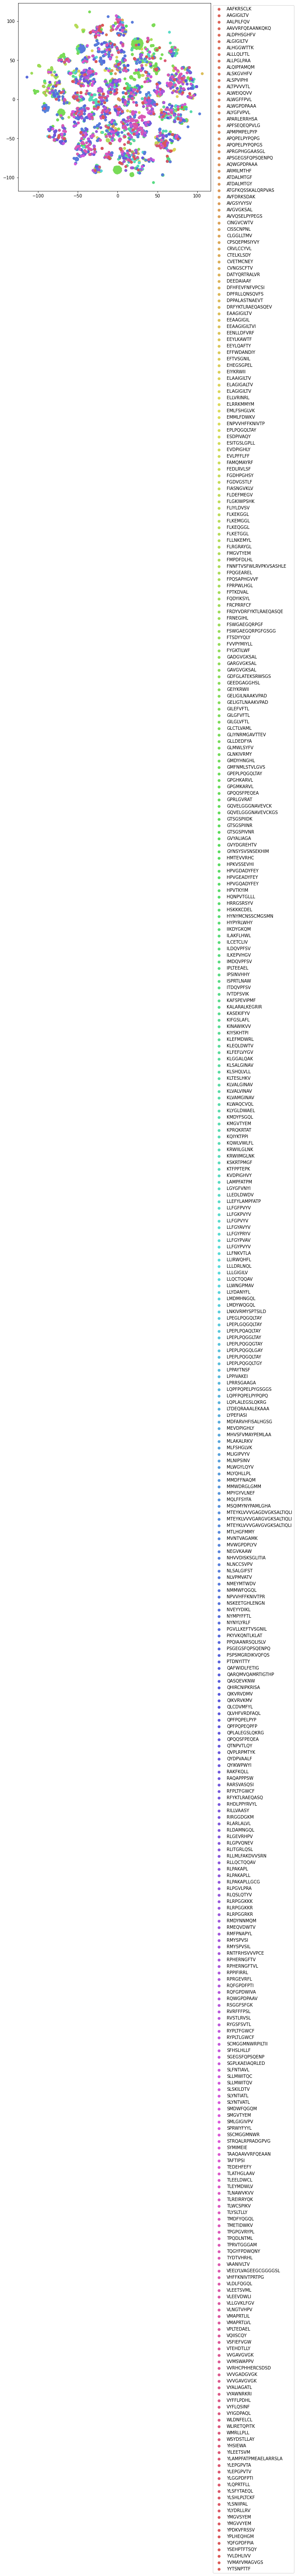

In [22]:
# pca100 = PCA(n_components=100)
# pca_fit = pca100.fit_transform(Nor_dist_matrix_beta)

TSNE_TRB = TSNE(random_state=42, perplexity=10, init='random', metric = 'precomputed').fit_transform(Nor_dist_matrix_beta)
TRB_spec_label, TRB_epitope = label_gen(VDJdb_TRB_Conf_human)

#TRA_TSNE_fit = TSNE_TRA.fit_transform(pca_fit)

draw_scatter(TRB_epitope, TSNE_TRB, TRB_spec_label)

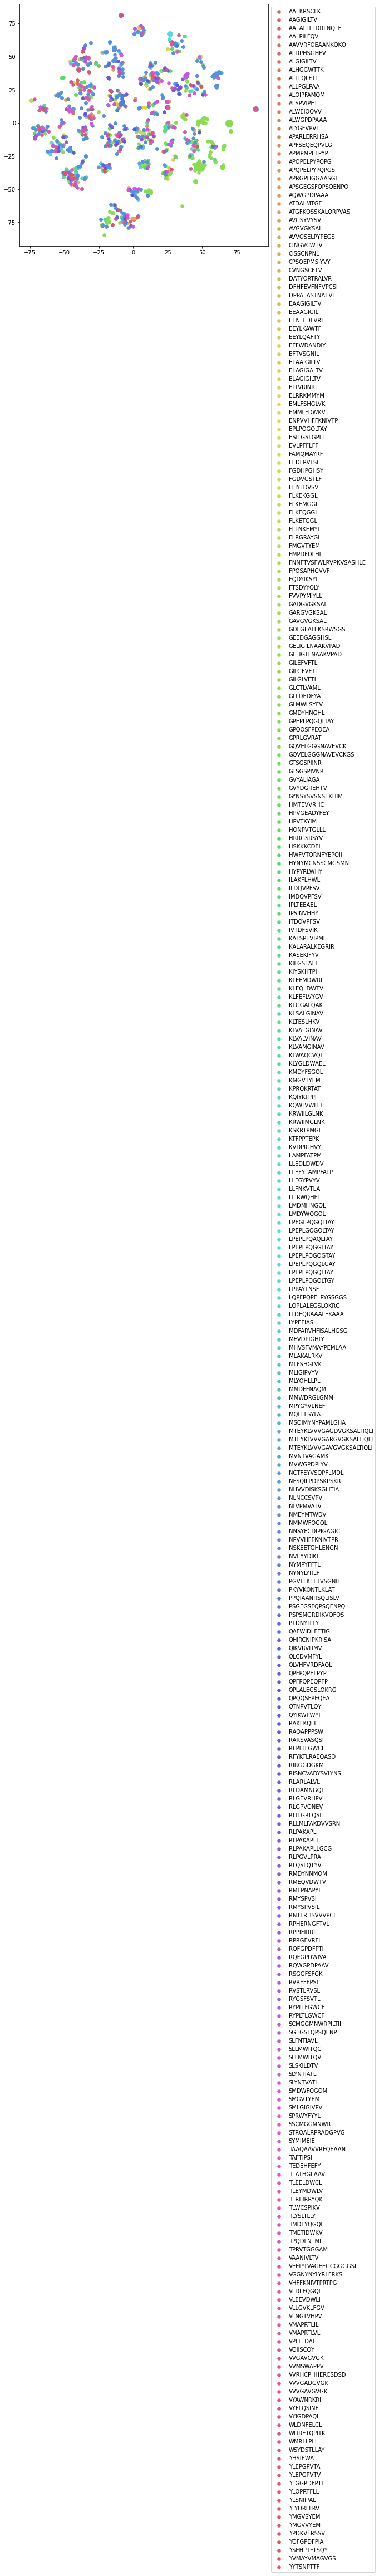

In [32]:
# pca100 = PCA(n_components=100)
# pca_fit = pca100.fit_transform(Nor_dist_matrix_beta)

TSNE_Paired = TSNE(random_state=42, perplexity=10, init='random', metric = 'precomputed').fit_transform(Nor_dist_matrix_beta)
Paired_spec_label, Paired_epitope = label_gen(VDJdb_Paired_Conf_human)

#TRA_TSNE_fit = TSNE_TRA.fit_transform(pca_fit)

draw_scatter(Paired_epitope, TSNE_Paired, Paired_spec_label)

In [34]:
TRA_labels_len = len(set(TRA_epitope))
TRA_Kmeans_cluster= cluster.KMeans(n_clusters = TRA_labels_len, random_state = 42)
TRA_umap_cluster_labels = TRA_Kmeans_cluster.fit_predict(TRA_umap_fit)
print(TRA_umap_cluster_labels)

D:\Anaconda Python\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\Anaconda Python\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


[137  82 143 ...  16  56  73]


In [36]:
TRA_labels_len = len(set(TRA_epitope))
TRA_Kmeans_cluster= cluster.KMeans(n_clusters = TRA_labels_len, random_state = 42)
TRA_tsne_cluster_labels = TRA_Kmeans_cluster.fit_predict(TSNE_TRA)
print(TRA_tsne_cluster_labels)

D:\Anaconda Python\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\Anaconda Python\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


[ 91   7 124 ... 186 252 144]


In [37]:
TRB_labels_len = len(set(TRB_epitope))
TRB_Kmeans_cluster= cluster.KMeans(n_clusters = TRB_labels_len, random_state = 42)
TRB_umap_cluster_labels = TRA_Kmeans_cluster.fit_predict(TRB_umap_fit)
print(TRB_umap_cluster_labels)

D:\Anaconda Python\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\Anaconda Python\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


[ 10  10 126 ... 302  71   9]


In [38]:
TRB_labels_len = len(set(TRB_epitope))
TRB_Kmeans_cluster= cluster.KMeans(n_clusters = TRB_labels_len, random_state = 42)
TRB_tsne_cluster_labels = TRA_Kmeans_cluster.fit_predict(TSNE_TRB)
print(TRB_tsne_cluster_labels)

D:\Anaconda Python\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\Anaconda Python\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


[ 65  65 283 ...  97  64 258]


In [41]:
Paired_labels_len = len(set(Paired_epitope))
Paired_Kmeans_cluster= cluster.KMeans(n_clusters = Paired_labels_len, random_state = 42)
Paired_umap_cluster_labels = Paired_Kmeans_cluster.fit_predict(Paired_umap_fit)
print(Paired_umap_cluster_labels)

D:\Anaconda Python\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\Anaconda Python\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


[ 30  30 249 ... 103  74  19]


In [42]:
Paired_labels_len = len(set(Paired_epitope))
Paired_Kmeans_cluster= cluster.KMeans(n_clusters = Paired_labels_len, random_state = 42)
Paired_tsne_cluster_labels = Paired_Kmeans_cluster.fit_predict(TSNE_Paired)
print(Paired_tsne_cluster_labels)

D:\Anaconda Python\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
D:\Anaconda Python\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


[ 65  65 283 ...  97  64 258]


In [26]:
score = silhouette_score(Nor_dist_matrix_alpha, TRA_cluster_labels, metric="precomputed")
print("TRA:", score)


TRA: 0.2687369762435426


In [49]:
random.seed(10)
umap_color_TRA = {}
for c in set(TRA_umap_cluster_labels):
    umap_color_TRA[c] = '#' + hex(random.randint(16, 255))[2:4] + hex(random.randint(16, 255))[2:4] + hex(random.randint(16, 255))[2:4]

umap_color_TRB = {}
for c in set(TRB_umap_cluster_labels):
    umap_color_TRB[c] = '#' + hex(random.randint(16, 255))[2:4] + hex(random.randint(16, 255))[2:4] + hex(random.randint(16, 255))[2:4]

tsne_color_TRA = {}    
for c in set(TRA_tsne_cluster_labels):
     tsne_color_TRA[c] = '#' + hex(random.randint(16, 255))[2:4] + hex(random.randint(16, 255))[2:4] + hex(random.randint(16, 255))[2:4]

tsne_color_TRB = {}
for c in set(TRB_tsne_cluster_labels):
    tsne_color_TRB[c] = '#' + hex(random.randint(16, 255))[2:4] + hex(random.randint(16, 255))[2:4] + hex(random.randint(16, 255))[2:4]

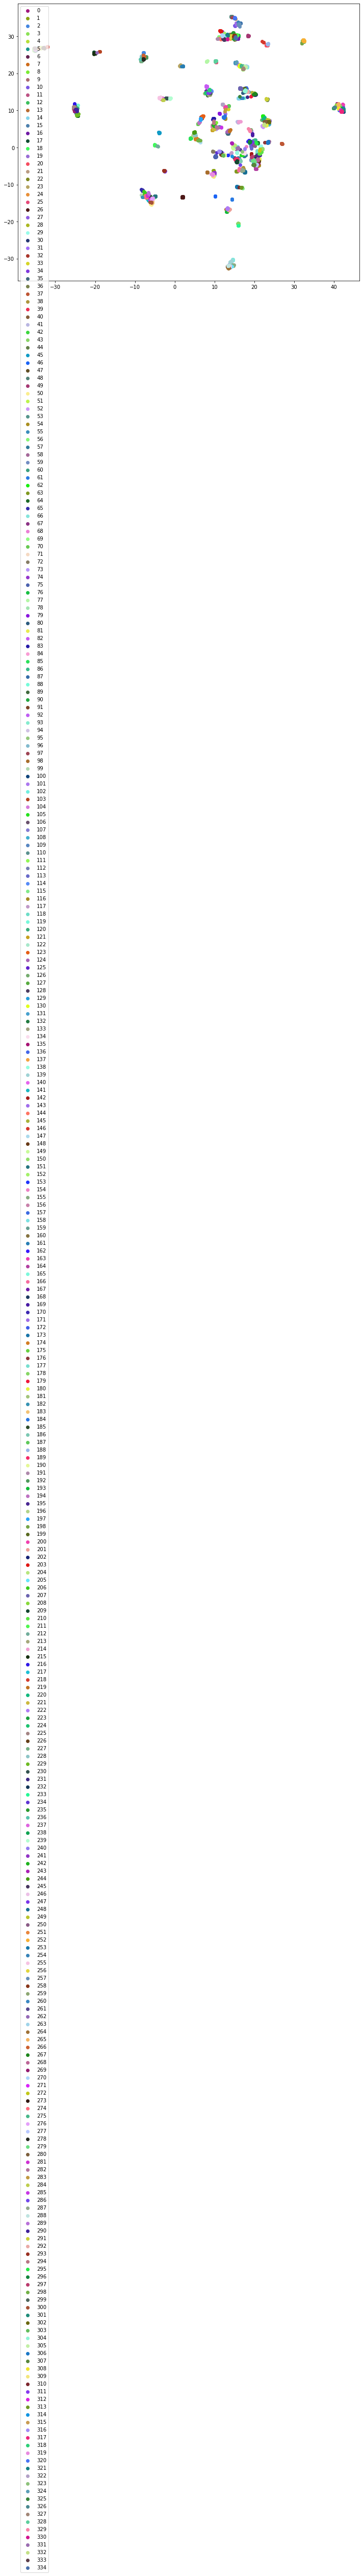

In [50]:
# Plot cluster result
plt.figure(figsize=(12,10))
for label in set(TRA_umap_cluster_labels):
    plt.scatter(TRA_umap_fit[TRA_umap_cluster_labels == label,0], 
                TRA_umap_fit[TRA_umap_cluster_labels == label,1], c=umap_color_TRA[label], label=label)
plt.legend()
plt.show()

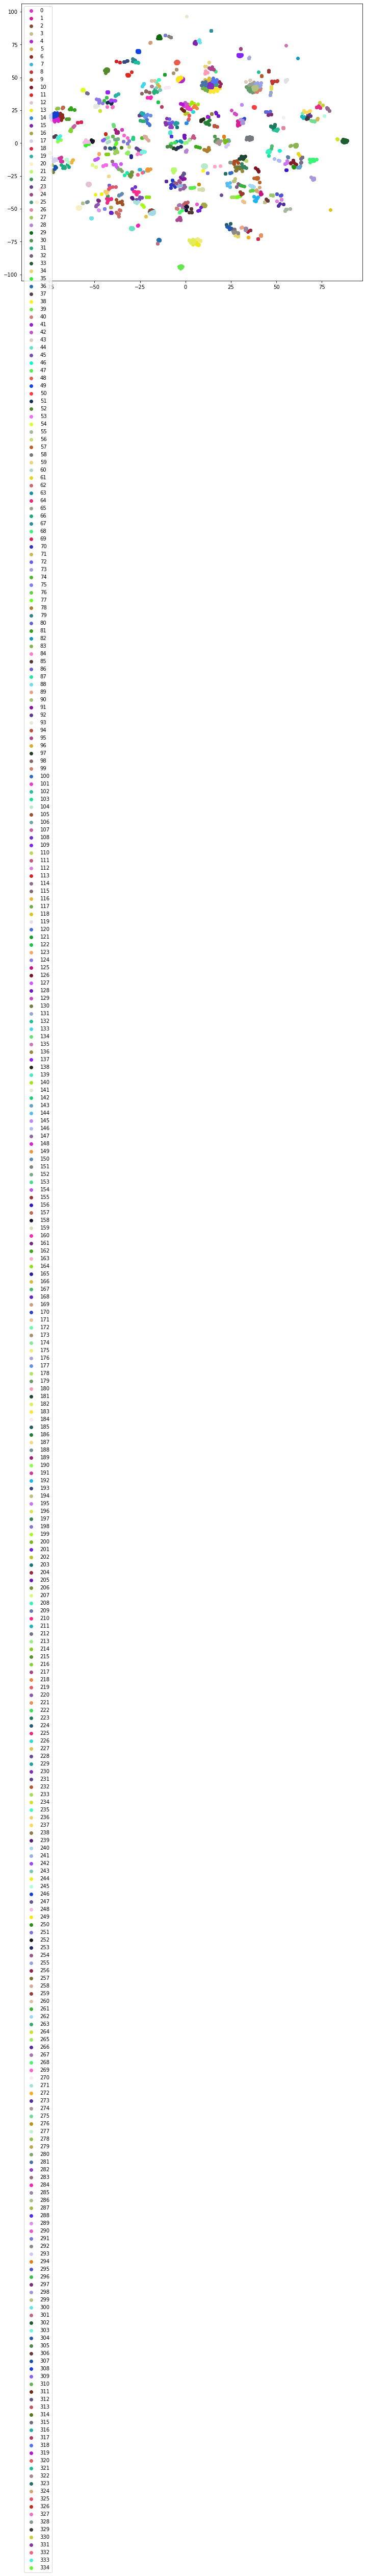

In [51]:
# Plot cluster result
plt.figure(figsize=(12,10))
for label in set(TRA_tsne_cluster_labels):
    plt.scatter(TSNE_TRA[TRA_tsne_cluster_labels == label,0], 
                TSNE_TRA[TRA_tsne_cluster_labels == label,1], c=tsne_color_TRA[label], label=label)
plt.legend()
plt.show()

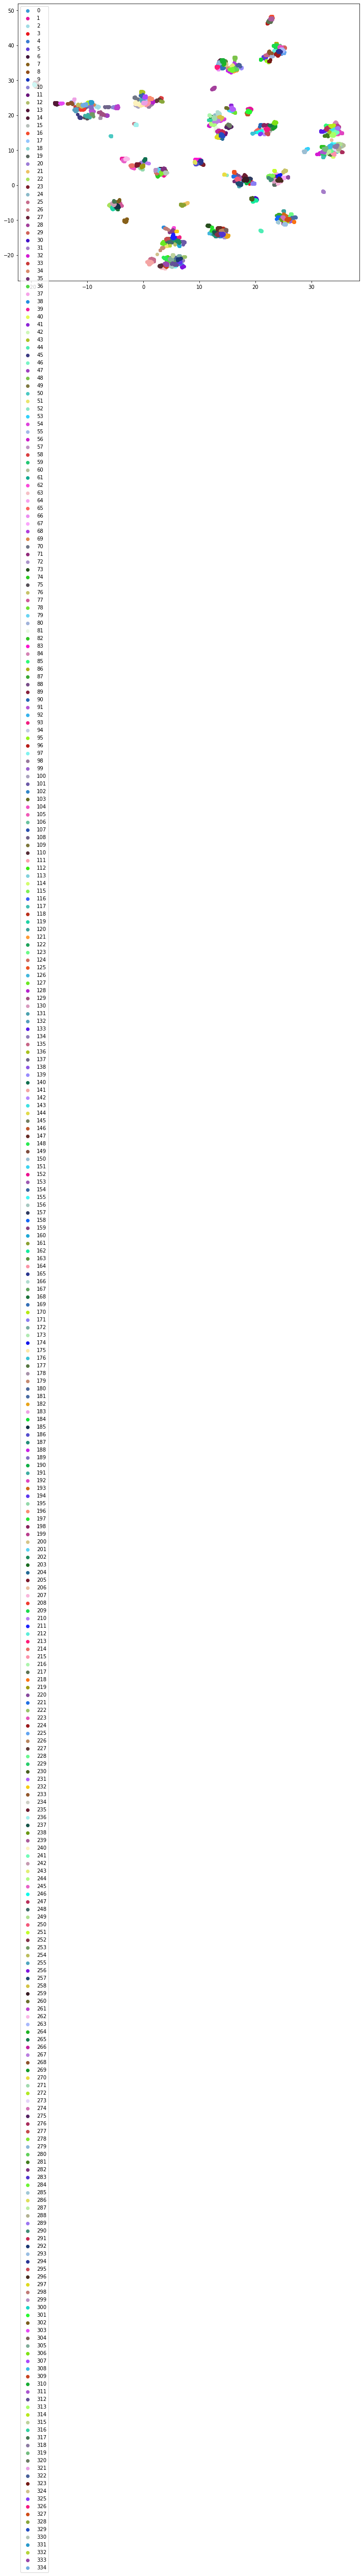

In [53]:
# Plot cluster result
plt.figure(figsize=(12,10))
for label in set(TRB_umap_cluster_labels):
    plt.scatter(TRB_umap_fit[TRB_umap_cluster_labels == label ,0], 
              TRB_umap_fit[TRB_umap_cluster_labels == label,1], c=umap_color_TRB[label], label=label)
plt.legend()
plt.show()

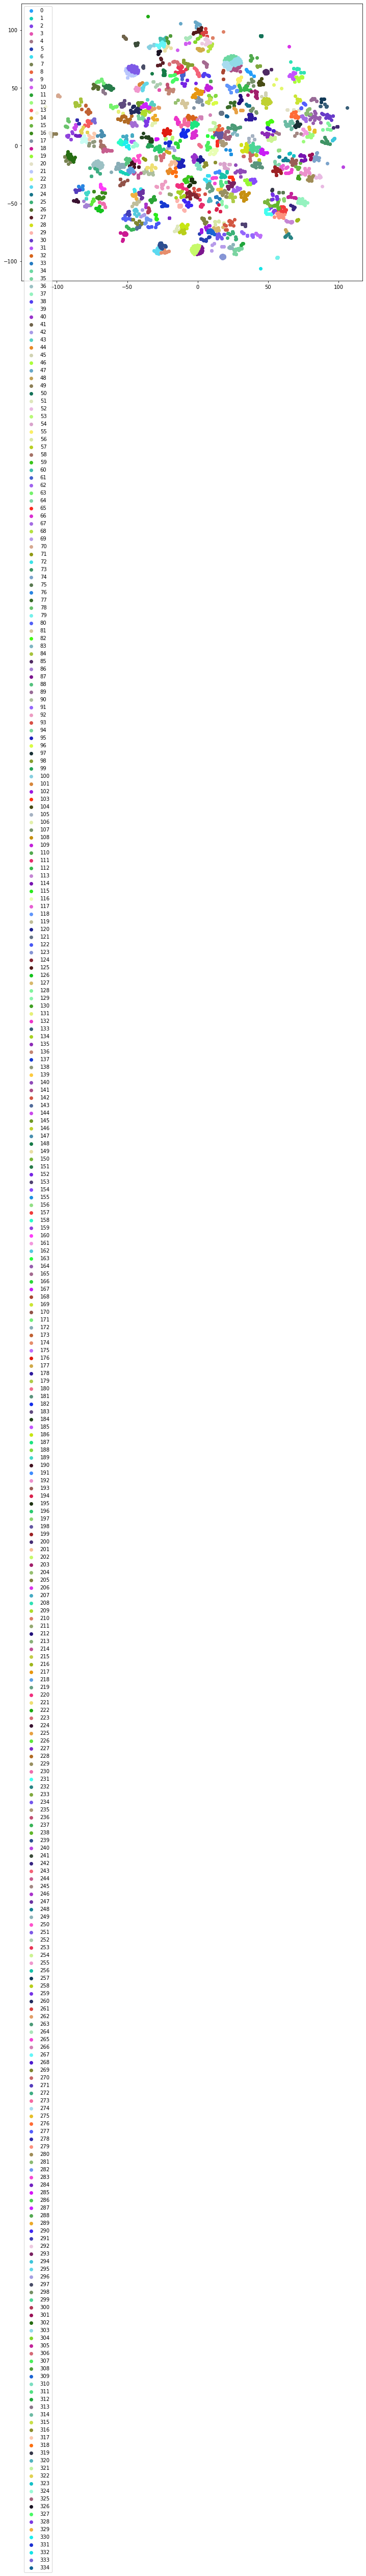

In [54]:
# Plot cluster result
plt.figure(figsize=(12,10))
for label in set(TRB_tsne_cluster_labels):
    plt.scatter(TSNE_TRB[TRB_tsne_cluster_labels == label ,0], 
              TSNE_TRB[TRB_tsne_cluster_labels == label,1], c=tsne_color_TRB[label], label=label)
plt.legend()
plt.show()

In [32]:
VDJ_test = VDJdb_TRA_human_fix
TRA_epitope_species = VDJ_test['antigen.epitope']
TRA_epitope_label = pd.Categorical(TRA_epitope_species).codes
TRA_labels_len = len(set(TRA_epitope_label))
print(TRA_epitope_label[1080])

TRA_spec_label_rep = pd.DataFrame({"antitope":TRA_epitope_species, "label":TRA_epitope_label})
TRA_spec_label = TRA_spec_label_rep.drop_duplicates(keep='first')
TRA_spec_label_rep.iloc[1080,:]

199


antitope    NEGVKAAW
label            199
Name: 1155, dtype: object

In [33]:
VDJ_test = VDJdb_TRB_human_fix
TRB_epitope_species = VDJ_test['epitope_aa']
TRB_epitope_label = pd.Categorical(TRB_epitope_species).codes
TRB_labels_len = len(set(TRB_epitope_label))
print(TRB_epitope_label[1080])

TRB_spec_label_rep = pd.DataFrame({"antitope":TRB_epitope_species, "label":TRB_epitope_label})
TRB_spec_label = TRB_spec_label_rep.drop_duplicates(keep='first')
TRB_spec_label_rep.iloc[1080,:]

242


antitope    NLVPMVATV
label             242
Name: 1083, dtype: object

In [35]:
# To print one cluster's label
label_index = np.where(TRB_cluster_labels == 8)
label_index = np.array(label_index).flatten()
#print(label_index)
TRA_label_repeat = TRA_spec_label_rep.iloc[label_index,:]
TRA_label_repeat = TRA_label_repeat["antitope"]
count = dict(Counter(TRA_label_repeat))
print(count)

{'LLFGYPVYV': 1, 'FLRGRAYGL': 1, 'NLVPMVATV': 2, 'VVMSWAPPV': 1, 'NEGVKAAW': 1, 'FRDYVDRFYKTLRAEQASQE': 7, 'MTEYKLVVVGAGDVGKSALTIQLI': 1}


In [57]:
# To print what labels contain in each cluster
def purity_compute(labels, spec_label_rep):
    Cluster_dic_tra_purity = []
    for l in set(labels):
        label_index = np.where(labels == l)
        if label_index != None:
            label_index = np.array(label_index).flatten()
            #print(label_index)
            TRA_label_repeat = spec_label_rep.iloc[label_index,:]
            TRA_label_repeat = TRA_label_repeat["antitope"]
            count = dict(Counter(TRA_label_repeat))
            count_values = count.values()
            purity = max(count_values)/sum(count_values)
            Cluster_dic_tra_purity.append(purity)
            # print(count)
    print(np.average(Cluster_dic_tra_purity))
    
print("TRA_UMAP: \n")
purity_compute(TRA_umap_cluster_labels, TRA_spec_label_rep)    
print("TRB_UMAP: \n")
purity_compute(TRB_umap_cluster_labels, TRB_spec_label_rep)    
print("TRA_TSNE: \n")
purity_compute(TRA_tsne_cluster_labels, TRA_spec_label_rep)
print("TRB_TSNE: \n")
purity_compute(TRB_tsne_cluster_labels, TRB_spec_label_rep)
    
# # To print what labels contain in each cluster
# Cluster_dic_trb_purity = []
# print("TRB_UMAP: \n")
# for l in set(TRB_cluster_labels):
#     label_index = np.where(TRB_cluster_labels == l)
#     if label_index != None:
#         label_index = np.array(label_index).flatten()
#         #print(label_index)
#         TRB_label_repeat = TRB_spec_label_rep.iloc[label_index,:]
#         TRB_label_repeat = TRB_label_repeat["antitope"]
#         count = dict(Counter(TRB_label_repeat))
#         count_values = count.values()
#         purity = max(count_values)/sum(count_values)
#         Cluster_dic_trb_purity.append(purity)
#         # print(count)
# print(np.average(Cluster_dic_trb_purity))

TRA_UMAP: 

0.5532414804978457
TRB_UMAP: 

0.4233920027256404
TRA_TSNE: 

0.5663532832733655
TRB_TSNE: 

0.431761506998158
